<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Базовые-модели" data-toc-modified-id="Базовые-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Базовые модели</a></span></li><li><span><a href="#Model-config" data-toc-modified-id="Model-config-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model config</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» c  BERT



Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
# !pip install torch
# !pip install torchmetrics

In [11]:
from pathlib import Path

COLAB_MODE = False

if COLAB_MODE:
    from google.colab import drive
    drive.mount('/content/drive')
    # ROOT = Path('drive/MyDrive/Colab_Notebooks/')
    %cd drive/MyDrive/Colab_Notebooks/toxic_comment_detection/

df_path = '../datasets/toxic_comments.csv'

# check files:
print(f">>> df path exists: {Path(df_path).exists()}")
print(f">>> requirements exists: {Path('requirements.txt').exists()}")



>>> df path exists: True
>>> requirements exists: True


In [12]:
#!pip install -r requirements.txt >> Null

In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
import re 


import os
from tqdm.notebook import tqdm

# import torch
# from transformers import BertTokenizer, BertModel
# import transformers

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

SEED = 41
MODEL_NAME = 'bert-base-uncased'


[nltk_data] Downloading package stopwords to /Users/ac1d/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def evaluate_and_report(report_df:pd.DataFrame, 
                        model, X, y, 
                        model_name, scoring='f1', 
                        predict_proba=False, 
                        thresh=0.3):
    '''
    Function to evaluate model and make report Dataframe
    '''
    
    report = pd.DataFrame()
    report.index = [model_name]
    if predict_proba:
        predicted = (model.predict_proba(X)[:,1] >= thresh).astype(int)
        report['f1'] = f1_score(y, predicted)
                       
                       
    else:
        predicted = model.predict(X)
        report['f1'] = f1_score(y, predicted)
    
    
    
    report.loc[:,'precision_0'] = precision_score(
        y, predicted, pos_label=0)
    report.loc[:,'precision_1'] = precision_score(
        y, predicted, pos_label=1)
    report.loc[:,'recall_0'] = recall_score(
        y, predicted, pos_label=0)
    report.loc[:,'recall_1'] = recall_score(
        y, predicted, pos_label=1)
    
    
    report_df = pd.concat([report_df, report])
    return report_df

## Подготовка

In [15]:
df = pd.read_csv(df_path)

In [16]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


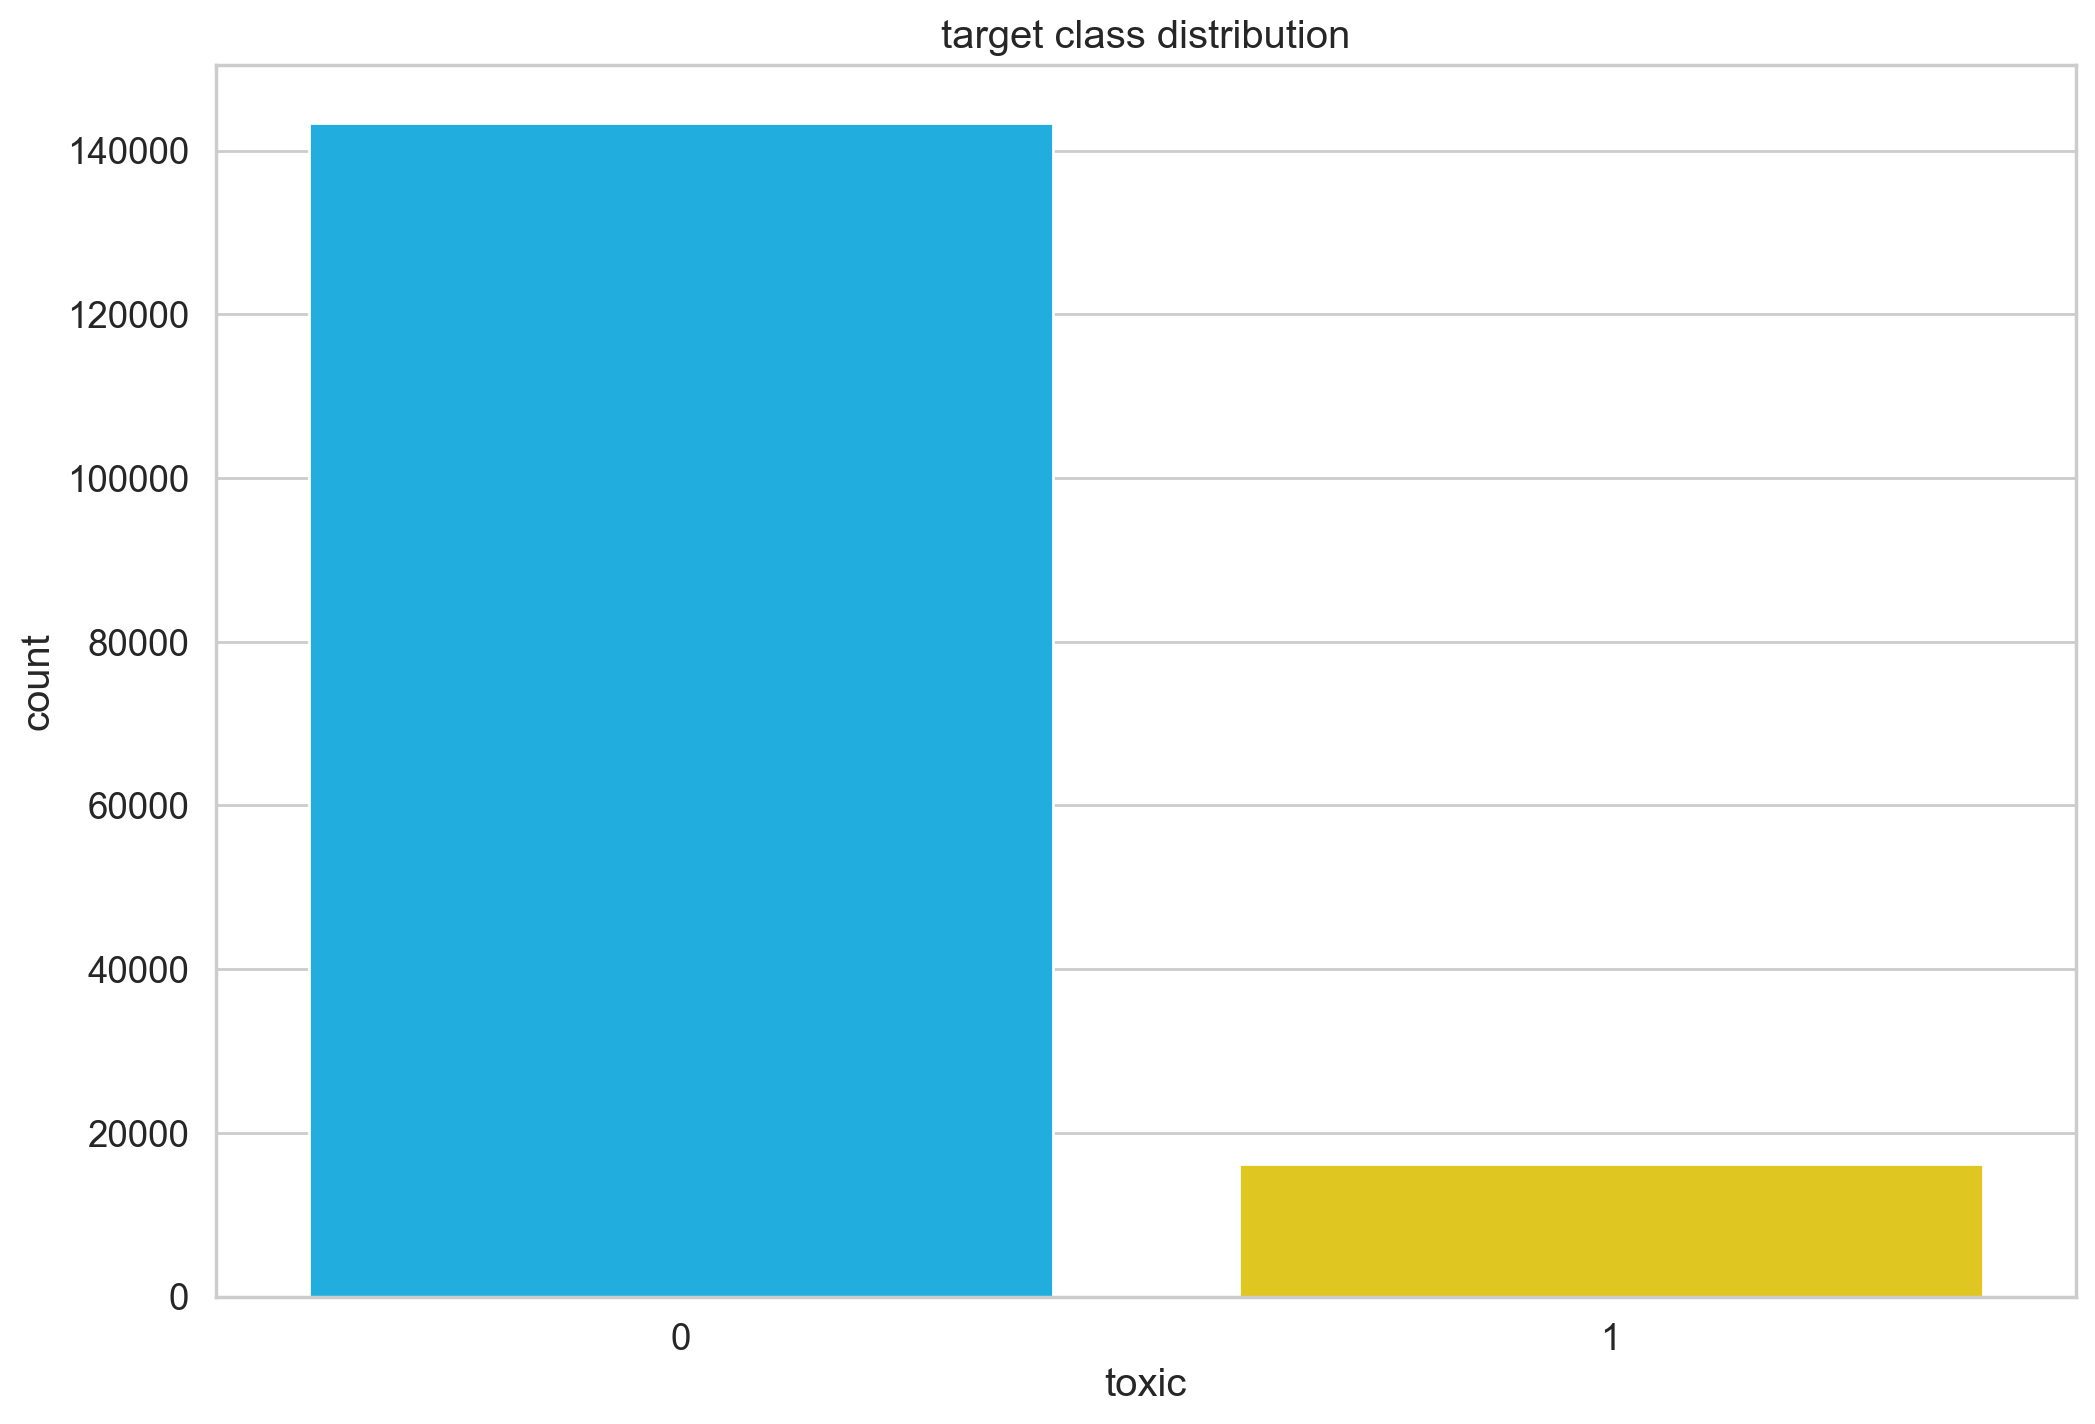

In [62]:
sns.countplot(data=df, x='toxic')
plt.title('target class distribution');

In [63]:
m = WordNetLemmatizer()
cleared = []

for i in tqdm(range(df.shape[0])):
    text = re.sub(r'[^a-zA-Z]', ' ', df['text'][i])
    text = m.lemmatize(text)
    text = ''.join(text)
    cleared.append(text)
df['lemmatize'] = cleared
df['lemmatize'][0]

  0%|          | 0/159571 [00:00<?, ?it/s]

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted  They weren t vandalisms  just closure on some GAs after I voted at New York Dolls FAC  And please don t remove the template from the talk page since I m retired now             '

In [64]:
df

,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m s...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when ...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for pr...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


In [65]:
stop_words = list(set(stopwords.words('russian')))
tfidf_vect = TfidfVectorizer(stop_words=stop_words)
    
transformed = tfidf_vect.fit_transform(df['lemmatize'])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(transformed, df.toxic,
                                                   test_size=.3)

## Обучение

### Базовые модели

In [67]:
# Baseline - logreg
logreg_model = LogisticRegression()

logreg_model.fit(X_train, y_train)

report_df = pd.DataFrame()
report_df = evaluate_and_report(report_df, logreg_model, X_test, y_test, 'logreg')
report_df

,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.728822,0.956232,0.934147,0.995233,0.597493


In [70]:
# Random forest
rf_model = RandomForestClassifier(random_state=SEED, 
                                  n_estimators=50,
                                  n_jobs=-1,
                                 verbose=1)

rf_model.fit(X_train, y_train)

report_df = evaluate_and_report(report_df, rf_model, X_test, y_test, 'random_forest')
report_df

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   58.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.728822,0.956232,0.934147,0.995233,0.597493
random_forest,0.551359,0.934885,0.968008,0.998558,0.385453


In [71]:
# lightGBM

lgb_model = LGBMClassifier(random_state=SEED)

lgb_model.fit(X_train, y_train)

LGBMClassifier(random_state=41)

In [72]:
report_df = evaluate_and_report(report_df, lgb_model, X_test, y_test, 'lightgbm')
report_df

,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.728822,0.956232,0.934147,0.995233,0.597493
random_forest,0.551359,0.934885,0.968008,0.998558,0.385453
lightgbm,0.753253,0.960239,0.922825,0.993977,0.636326


In [74]:
report_df = evaluate_and_report(report_df, lgb_model, X_test, y_test, 'lightgbm_thresh_0.3', predict_proba=True)
report_df

,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.728822,0.956232,0.934147,0.995233,0.597493
random_forest,0.551359,0.934885,0.968008,0.998558,0.385453
lightgbm,0.753253,0.960239,0.922825,0.993977,0.636326
lightgbm_thresh_0.3,0.776798,0.969202,0.838372,0.984211,0.723649
lightgbm_thresh_0.3,0.776798,0.969202,0.838372,0.984211,0.723649


# Bert

In [75]:
# !pip install torch torchmetrics transformers wandb

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/torch/lib/python3.10/threading.py", line 1016, in _bootstrap_inner


In [ ]:
# here some variables reassigned and some modules reimported, to run experiments with BERT exact from this point 

In [3]:
# import pandas as pd
# import numpy as np
# import os
# from pathlib import Path

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, precision_score, recall_score


# # WandB – Import the wandb library
import wandb
# import pickle

# from tqdm.notebook import tqdm

# import torch
from transformers import AutoTokenizer, BertModel

from transformers import BertForSequenceClassification, AdamW, BertConfig
# import platform
# from torch.optim import AdamW
from func import *
import pandas as pd
import random
import platform
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, random_split


    
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

df_path = '../datasets/toxic_comments.csv'

### Model config

In [4]:
MODEL_NAME = 'bert-base-uncased'  # parameter for download pretrained model and tokenizer
MAX_LENGTH = 400  # length to truncate

EPOCHS = 3
BATCH_SIZE = 8
LEARNING_RATE = 3e-5
LOG_INTERVAL = 100
FRAQ = 0.3 # perc of data to use. needed for debug mode
# wandb
USE_WANDB = True
os.environ["WANDB_MODE"]="offline"

PROJECT_NAME = 'toxic_comment_detection'
RUN_NAME = 'bert random sampler'
# Number of training epochs. The BERT authors
# recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
DEVICE = choose_device(platform.system())

SAVE_PATH = f'saved_models/{MODEL_NAME}'
TOKENIZED_PATH = 'encoded_dict.pkl'

In [5]:
# original paper text:
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [8]:
df = pd.read_csv(df_path)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokens_dict = make_tokens(tokenizer, df, TOKENIZED_PATH, MAX_LENGTH, fraq=FRAQ)

making tokens: 100%|████████████████| 47871/47871 [00:09<00:00, 4794.99it/s]


In [9]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(tokens_dict['input_ids'], tokens_dict['attention_masks'], tokens_dict['labels'])

train_size = int(0.70 * len(dataset))
val_size, test_size = int(len(dataset) - train_size) // 2, int(len(dataset) - train_size) // 2

# # Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset  = random_split(dataset, [train_size, val_size, test_size])

print(f'{train_size:>5,} train samples')
print(f'{val_size:>5,} validation samples')
print(f'{test_size:>5,} test samples')

33,509 train samples
7,181 validation samples
7,181 test samples


In [10]:
from torch.utils.data import WeightedRandomSampler
# Compute class weights for weighted sampler
target = [t[2].item() for t in train_dataset]
class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# batch_size = 32 

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
#             sampler = RandomSampler(train_dataset), # Select batches randomly
            sampler=sampler,
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )
test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size = BATCH_SIZE
)

In [11]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
)

model.to(DEVICE)
print(f">>> Training on: {DEVICE}")


train_loop(model, train_dataloader, validation_dataloader, 
           EPOCHS, 
           LEARNING_RATE, 
           SAVE_PATH, 
           device=DEVICE, 
           use_wandb=USE_WANDB,
           proj_name=PROJECT_NAME,
          run_name=RUN_NAME,
           log_interval=LOG_INTERVAL
          )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

>>> Training on: mps
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
hugging

  0%|                                                 | 0/3 [11:07<?, ?it/s]


KeyboardInterrupt: 

## Выводы

In [18]:
for i in range(1000):
    if i % 600 == 99:
        print(i)

99
699


- Наш датасет имеет дисбаланс классов, токсичных комментариев значительно меньше обычных.
- хорошо видно, что именно полнота класса 1 имеет низкие значения, что вносит свой вклад в низкую оценку f1.
- Для нашей задачи не страшно, если мы неправильно пометим нетоксичные комментарии в небольших количествах случаев (False Positive)
поэтому для борьбы с дисбалансом классов принято решение изменить порог логистической регрессии с 0.5 до 0.3. 
- Результат по прохождению необходимого порога метрики F1 достигнут. 

**Bert**

- Запустить bert удалось только с помощью огромной простыни выше. Долго пытался запустить с помощью catalyst, создавал датасеты, даталоадеры, упаковывал всё в словари, но получал ошибку **KeyError: 'Indexing with integers (to access backend Encoding for a given batch index) is not available when using Python based tokenizers' site:stackoverflow.com**
В гугле способ решения не нашёл.

-  Мне удалось запустить BERT на GPU в google colab. Для отладки кода я использовал размер выборки 1000 с разделением на трэйн и валидацию. На этом этапе были фантастические метрики по accuracy и f1(0.96), настораживает, правда, что они в точности совпадали по значениям. 
![title](colab.png)

- На выборке ~10% от датасета на двух эпохах, с метриками произошла какая-то беда. Лосс стал возрастать, f1 и accuracy ниже разумного порога. 
- К сожалению colab выкинул меня из gpu из-за ограничений на время выполнения, поэтому для однозначных выводов у меня сейчас нет ресурсов. Однако, думаю, что если применить fine-tuning(обновить весов последнего слоя), можно добиться очень хороших результатов. 

- Обучение на локальном компьютере прервал, т.к. нет времени ждать. Позже продолжу эксперименты в google colab. 
